<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Model_reactor_1D_steady_state_isothermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load libraries

In [ ]:
# @title import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch as to
from scipy.integrate import odeint

In [ ]:
# @title check library versions
print("tensorflow:" + str(tf.__version__))
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

tensorflow:2.13.0
numpy:1.23.5
pandas:1.5.3


# setup

**Indexing in arrays:**

\begin{array}{lllll}
H_2 & H_2O & CO & CO_2 & CH_3OH \\
0 & 1 & 2 & 3 & 4 \\
\end{array}

In [ ]:
# @title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

T = 273 + 140 # reactor temperature [K]

L_R = 0.720               # reactor length [m]
d_R = 0.133               # reactor diameter [m]
r_R = d_R/2               # reactor radius [m]
A_R = np.pi*np.power(r_R, 2, dtype=float)            # reactor crossectional area [a.u.]
V_R = A_R*L_R             # reactor volume [m^3]
m_cat = 7950 / 1000       # catalyst mass [g]
dens_cat = 3.28426        # catalyst density [g cm^-3]
p_in = 1                  # inlet pressure [bar]
n_Flow_total = 8.36812    # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5           # inlet molefraction methanol
x_H2O_in = 0.5            # inlet molefraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]
VFlow = n_Flow_total/p_in                         # volumetric flowrate [a.u.]
m_cat_0 = 0               # starting mass of catalyst [g] !! typically 0
steps = 10              # number of steps in numerical calculation
dm_cat = (m_cat-m_cat_0)/steps                    # finite differential for numerical integration
m_cat_span = np.arange(m_cat_0, m_cat + dm_cat, dm_cat)   # range of mass segments for integration and plotting
R = 8.314                 # universal gas constant [J mol-1 K-1]
VFlow = n_Flow_total * R * T / (p_in * np.power(10, 5, dtype = float))

# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
#print(Vspansplit)
#print(n_Flow_in_MeOH)

In [ ]:
# @title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

# P0_H2 = 0                       # [bar]
# P0_H2O = p_in*x_MeOH_in         # [bar]
# P0_CO = 0                       # [bar]
# P0_CO2 = 0                      # [bar]
# P0_MeOH = p_in*x_H2O_in         # [bar]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])
# IP = np.array([P0_H2, P0_H2O, P0_CO, P0_CO2, P0_MeOH, m_cat_0])


In [ ]:
# @title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 4.2*10**(-6)       # k0 for arrhenius[kmol kg-1 h-1]
EA_MSR_S = 4.978*1000         # activation energy [J mol-1]
b_MeOH_MSR_S = - 0.428        # rate of reaction exponent for methanol
b_H2O_MSR_S = - 0.949         # rate of reaction exponent for water

MSR = np.array(
    [k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S]
)

#MD
k0_MD_S = 5.5*10**(-8)        # [kmol kg-1 h-1]
EA_MD_S = 42.137*1000         # [J mol-1]
b_MeOH_MD_S = 0.114

MD = np.array (
    [k0_MD_S, EA_MD_S, b_MeOH_MD_S]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


#print(MSR)
#print(MD)
#print(WGS)
#print(ny)

# PFTR isothermal and steady state

ODE by mass catalyst:

$\frac{dp_x}{dm_{cat}}$=$\frac{R⋅T}{\dot{V}}$⋅$R_x$

In [ ]:
# @title reaction functions

def ReakFun (P, T):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))
  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0]*np.power((T/T0), n, dtype=float)*np.exp((-MSR[1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[2], dtype=float) * np.power(P_H2O, MSR[3], dtype=float)


  rMD = MD[0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[2], dtype=float)

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1

  return dP


In [ ]:
# @title euler's method

def EulFun (y, T):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(IC)])
  ytemp[0,:] = y

  for i in range(steps):
    y = np.transpose(ytemp[i, :])
    for j in range(5):
      y[j] = y[j] * R * T / VFlow / 100
    dy = ReakFun(y, T)
    ytemp[i+1, :] = y + dy*dm_cat

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp


In [ ]:
# @title Runge Kutta fourth order function

def RK4FunMSRMD (y, T, MSRind, MDind):
  '''
  similarily to euler's method, the runge kutta method of the fourth order calculates the integral using finite differentials
  runge kutta uses 4 slopes to calculate a mean slope along the graph -> more accurate
  this function handles the first reactor containing MSR and MD catalyst
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  for i in range(stepssplit):
    V = Vspan[i]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunMSRMD(y, T, MSRind, MDind)
    k2 = ReakFunMSRMD(y + 0.5*k1, T, MSRind, MDind)
    k3 = ReakFunMSRMD(y + 0.5*k2, T, MSRind, MDind)
    k4 = ReakFunMSRMD(y + k3*dV, T, MSRind, MDind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV

  return ytemp

def RK4FunWGS (y, T, WGSind):
  '''
  similarily to euler's method, the runge kutta method of the fourth order calculates the integral using finite differentials
  runge kutta uses 4 slopes to calculate a mean slope along the graph -> more accurate
  this function handles the second reactor containing the WGS catalyst
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(Vspansplit), len(IC)])
  ytemp[0,:] = y

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  for i in range(stepssplit):
    V = Vspan[i + stepssplit - 1]
    y = np.transpose(ytemp[i, :])
    k1 = ReakFunWGS(y, T, WGSind)
    k2 = ReakFunWGS(y + 0.5*k1, T, WGSind)
    k3 = ReakFunWGS(y + 0.5*k2, T, WGSind)
    k4 = ReakFunWGS(y + k3*dV, T, WGSind)
    ytemp[i+1, :] = y + 1/6*(k1 + 2*k2 + 2*k3 + k4)*dV

  return ytemp

# main

In [ ]:
'''
contains main function to call all other relevant functions and set temperature and reaction index
'''

# calculates a concentration array using euler's method, with the length Vspan for plotting
pEul = EulFun(IC, T)

# calculates a concentration array using the runge kutta method of the fourth order, with the length Vspan for plotting
#pRK = RK4Fun(IC, T)

# Pressure array testing

# print (ConcRK)
# print (Conctemp2)
# print(pEul)

test = ReakFun(IC, T)
print(pEul)
print(test*dm_cat)

[[0.00000000e+00 5.00000000e-01 0.00000000e+00 0.00000000e+00
  5.00000000e-01 0.00000000e+00]
 [2.94033114e-03 5.97495994e+01 3.52696276e-06 9.77759070e-04
  5.97495959e+01 7.95000000e-01]
 [3.51389178e-01 7.14014610e+03 4.27560559e-04 1.16844686e-01
  7.14014568e+03 1.59000000e+00]
 [4.19914334e+01 8.53255702e+05 5.11044768e-02 1.39630748e+01
  8.53255651e+05 2.38500000e+00]
 [5.01802480e+03 1.01965041e+08 6.10706208e+00 1.66860356e+03
  1.01965035e+08 3.18000000e+00]
 [5.99659756e+05 1.21849401e+10 7.29801000e+02 1.99400051e+05
  1.21849394e+10 3.97500000e+00]
 [7.16600331e+07 1.45611441e+12 8.72120620e+04 2.38285363e+07
  1.45611433e+12 4.77000000e+00]
 [8.56345668e+09 1.74007353e+14 1.04219421e+07 2.84753760e+09
  1.74007343e+14 5.56500000e+00]
 [1.02334296e+12 2.07940796e+16 1.24543411e+09 3.40284030e+11
  2.07940784e+16 6.36000000e+00]
 [1.22290665e+14 2.48491652e+18 1.48830814e+11 4.06643344e+13
  2.48491637e+18 7.15500000e+00]
 [1.22290665e+14 2.48491652e+18 1.48830814e+11 4.0

# plots

Text(0, 0.5, 'pressure [bar]')

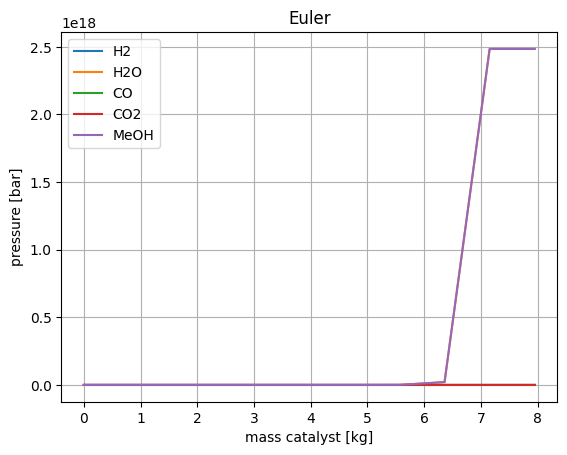

In [ ]:
# @title full plot

'''
plots both reactors in the cascade using euler's method and the runge kutta method
'''

plt.figure(1)
plt.plot(pEul[:,5], pEul[:,0], label='H2')
plt.plot(pEul[:,5], pEul[:,1], label='H2O')
plt.plot(pEul[:,5], pEul[:,2], label='CO')
plt.plot(pEul[:,5], pEul[:,3], label='CO2')
plt.plot(pEul[:,5], pEul[:,4], label='MeOH')
plt.title("Euler")
#plt.axis((0, 8000, 0, 1))
plt.legend(loc='best')
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("pressure [bar]")


# reactions

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \end{array}
